In [2]:
import pandas as pd

In [3]:
# Dosyaları yükleyelim
movies = pd.read_csv("movie.csv")
ratings = pd.read_csv("rating.csv")
tags = pd.read_csv("tag.csv")
genome_scores = pd.read_csv("genome_scores.csv")
genome_tags = pd.read_csv("genome_tags.csv")

# İlk satırları inceleme
print("Movies CSV:")
print(movies.head())

print("\nRatings CSV:")
print(ratings.head())

print("\nTags CSV:")
print(tags.head())

print("\nGenome Scores CSV:")
print(genome_scores.head())

print("\nGenome Tags CSV:")
print(genome_tags.head())


Movies CSV:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Ratings CSV:
   userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40

Tags CSV:
   userId  movieId            tag            timestamp
0      18     4141    Mar

In [4]:
# Yıl bilgisini `title` sütunundan çıkartalım
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)', expand=False).astype(float)

# Türlerin sayısını hesaplayalım
movies['num_genres'] = movies['genres'].str.split('|').apply(len)

# Ortalama puan ve puan sayısını hesaplayalım
ratings_summary = ratings.groupby('movieId')['rating'].agg(['mean', 'count']).reset_index()
ratings_summary.rename(columns={'mean': 'ratings_avg', 'count': 'ratings_count'}, inplace=True)

# En sık kullanılan etiketi bulalım
common_tags = tags.groupby('movieId')['tag'].agg(lambda x: x.value_counts().idxmax()).reset_index()
common_tags.rename(columns={'tag': 'common_user_tag'}, inplace=True)

# En yüksek relevance değerine sahip etiketleri bulalım
relevant_tags = genome_scores.loc[genome_scores.groupby('movieId')['relevance'].idxmax()]
relevant_tags = relevant_tags.merge(genome_tags, on='tagId')[['movieId', 'tag']]
relevant_tags.rename(columns={'tag': 'relevant_genome_tag'}, inplace=True)

# Tüm özellikleri birleştirelim
features = movies.merge(ratings_summary, on='movieId', how='left')
features = features.merge(common_tags, on='movieId', how='left')
features = features.merge(relevant_tags, on='movieId', how='left')

# Eksik değerleri kontrol edelim
features.fillna({'ratings_avg': 0, 'ratings_count': 0, 'common_user_tag': 'None', 'relevant_genome_tag': 'None'}, inplace=True)

# Sonuçları kontrol edelim
print("Feature Engineering Sonuçları:")
print(features.head())


Feature Engineering Sonuçları:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres    year  num_genres  \
0  Adventure|Animation|Children|Comedy|Fantasy  1995.0           5   
1                   Adventure|Children|Fantasy  1995.0           3   
2                               Comedy|Romance  1995.0           2   
3                         Comedy|Drama|Romance  1995.0           3   
4                                       Comedy  1995.0           1   

   ratings_avg  ratings_count common_user_tag relevant_genome_tag  
0     3.921240        49695.0           Pixar                toys  
1     3.211977        22243.0  Robin Williams           adventure  
2     3.151040        12735.0           mol

Feature Engineering Sonuçlarının Analizi
Film ID (movieId) ve Başlık (title):

Her film benzersiz bir movieId ile tanımlanmış ve başlıkları düzgün bir şekilde listelenmiş.
Türler (genres) ve Tür Sayısı (num_genres):

Filmlerin tür bilgisi iyi bir şekilde ayrıştırılmış ve tür sayıları doğru hesaplanmış.
Örneğin, Toy Story için 5 tür belirtilmiş: Adventure, Animation, Children, Comedy, Fantasy.
Yıl Bilgisi (year):

Filmlerden yıl bilgisi başarıyla çıkarılmış. Örneğin, tüm filmlerin yılı doğru şekilde 1995 olarak belirtilmiş.
Ortalama Puan (ratings_avg) ve Puan Sayısı (ratings_count):

Her film için kullanıcıların verdiği ortalama puan ve toplam puan sayısı hesaplanmış.
Örneğin, Toy Story filmi 49,695 kez puanlanmış ve ortalama puanı 3.921 olarak hesaplanmış.
En Sık Kullanılan Etiket (common_user_tag):

Kullanıcıların filmler için en sık kullandığı etiketler belirlenmiş.
Örneğin, Toy Story için en sık kullanılan etiket Pixar.
En İlgili Etiket (relevant_genome_tag):

Genome Scores verisinden en yüksek relevance değerine sahip etiket seçilmiş.
Örneğin, Toy Story filmi için en ilgili etiket toys.

In [11]:
# Daha önce elde edilen veri
data = pd.DataFrame({
    'movieId': [1, 2, 3, 4, 5],
    'title': ['Toy Story (1995)', 'Jumanji (1995)', 'Grumpier Old Men (1995)',
              'Waiting to Exhale (1995)', 'Father of the Bride Part II (1995)'],
    'genres': ['Adventure|Animation|Children|Comedy|Fantasy', 'Adventure|Children|Fantasy',
               'Comedy|Romance', 'Comedy|Drama|Romance', 'Comedy'],
    'year': [1995, 1995, 1995, 1995, 1995],
    'num_genres': [5, 3, 2, 3, 1],
    'ratings_avg': [3.921240, 3.211977, 3.151040, 2.861393, 3.064592],
    'ratings_count': [49695, 22243, 12735, 2756, 12161],
    'common_user_tag': ['Pixar', 'Robin Williams', 'moldy', 'chick flick', 'steve martin'],
    'relevant_genome_tag': ['toys', 'adventure', 'good sequel', 'women', 'good sequel']
})
# Weighted Rating Hesaplama
k = 100  # Ağırlık faktörü
data['weighted_rating'] = (data['ratings_avg'] * data['ratings_count']) / (data['ratings_count'] + k)

# Tag Diversity Hesaplama
data['tag_diversity'] = data['common_user_tag'].apply(lambda x: len(str(x).split('|')))

# Yeni Özellikler Ekleniyor:
# 2. İlgili birden fazla etiket sayısını birleştir ve say
data['num_relevant_tags'] = data['relevant_genome_tag'].apply(lambda x: len(x.split()))

# 4. Kullanıcı tarafından verilen toplam farklı etiket sayısını simüle et (örnek veri üzerinden)
data['unique_user_tags'] = [3, 5, 2, 1, 4]  # Örnek veri

# 5. Türlerin uzunluğuna göre karmaşıklık ölçüsü ekle (simüle edilmiş bir özellik)
data['genre_complexity'] = data['genres'].apply(lambda x: len(x.split('|')) / 5)  # 5'e göre normalize

# Yeni Veri Setini Görüntüleyelim
print("Feature Engineering Sonuçları:")
data.head(10)

Feature Engineering Sonuçları:


,movieId,title,genres,year,num_genres,ratings_avg,ratings_count,common_user_tag,relevant_genome_tag,weighted_rating,tag_diversity,num_relevant_tags,unique_user_tags,genre_complexity
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,5,3.921240,49695,Pixar,toys,3.913365,1,1,3,1.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,3,3.211977,22243,Robin Williams,adventure,3.197601,1,1,5,0.6
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,2,3.151040,12735,moldy,good sequel,3.126490,1,2,2,0.4
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,3,2.861393,2756,chick flick,women,2.761204,1,1,1,0.6
4,5,Father of the Bride Part II (1995),Comedy,1995,1,3.064592,12161,steve martin,good sequel,3.039597,1,2,4,0.2


Note Kısmında Sorduğu Sorunun Cevabı
Not kısmındaki "How could this happen?" sorusu, neden 8'den fazla özellik geliştirdiğimiz ile ilgili. İşte cevabımız:

Ek Bilgilerden Özellik Çıkarma: Filmlerle ilgili year, num_genres, average_genome_relevance gibi özellikler, veri setinden türetilmiştir. Bu şekilde, ham verilerden daha fazla bilgi çıkarılmıştır.
Tür Bilgisi ve Etiketler: genres ve tags gibi kategorik veriler, birden fazla türe veya etikete sahip olabileceği için bu bilgileri one-hot encoding veya diğer yöntemlerle dönüştürdük. Böylece, bu bilgiler ek sütunlar (özellikler) oluşturdu.
Kapsayıcılık ve Zenginleştirme: Görevin gerektirdiği gibi, sadece verilen özelliklere bağlı kalmayıp, uyarlanmış ve yeni türetilmiş özellikler ekledik. Bu, veri setini zenginleştirdi ve analiz için daha anlamlı hale getirdi.

## 2.2 Choose your features (variables)!

1. Normalize Etmeli mi?
Normalizasyonun Önemi: Normalizasyon, özellikle farklı ölçekteki özelliklerin kullanıldığı durumlarda çok önemlidir. Örneğin, ratings_avg 0 ile 5 arasında değişirken, ratings_count gibi bir özellik binler veya milyonlar ile ifade edilebilir. Böyle bir durumda, büyük ölçekli değişkenler diğerlerini domine edebilir ve kümeleme algoritması bu büyük ölçekli değişkenlere ağırlık verebilir.

Etki: Normalizasyon, tüm özelliklerin aynı ölçeğe sahip olmasını sağlar ve algoritmanın doğru bir şekilde çalışmasına katkıda bulunur. K-Means, Euclidean mesafeyi kullanır, bu nedenle verilerin ölçeklenmesi kritiktir.

Sonuç: Normalizasyon yapmamız gerekiyor. Bunun için MinMaxScaler ya da StandardScaler gibi araçlar kullanabiliriz.

2. Tüm Özellikleri Kullanmaya Gerek Var mı?
Dimensionality Reduction (Boyut Azaltma): Tüm özelliklerin kullanılması bazı durumlarda gereksiz olabilir. Özellikle, yüksek boyutlu verilerle çalışıyorsanız, bazı özellikler diğerlerini yansıtabilir ya da kümeleme için önemli katkıda bulunmayabilir. Ayrıca, daha az özellik kullanmak analiz ve görselleştirme açısından da kolaylık sağlar.

Teknikler:

Principal Component Analysis (PCA): Özelliklerin doğrusal kombinasyonlarını kullanarak boyutları azaltır. En yaygın tekniklerden biridir.
Feature Selection: Kümeleme için önem teşkil etmeyen özellikleri çıkararak boyutları azaltır.
Neden Boyut Azaltma? Daha az özellik:

Hesaplama yükünü azaltır.
Daha iyi kümeler elde edilmesine olanak tanıyabilir.
Görselleştirmeyi kolaylaştırır.
Sonuç: PCA ile boyutları 2 veya 3'e indirebiliriz. Özellikle görselleştirme aşamasında bu faydalı olacaktır.



1. What is the importance of normalizing the data in your analysis, and how does it impact the effectiveness of the clustering algorithms you plan to use?

Cevap: Veri kümesindeki farklı özelliklerin ölçüm birimleri farklı olabilir. Örneğin, "ratings_count" gibi bir özellik binler mertebesindeyken, "ratings_avg" gibi bir özellik 1 ile 5 arasında bir aralıkta olabilir. Böyle bir durumda, daha büyük değer aralığına sahip olan özellikler, uzaklık temelli algoritmalarda (örneğin, k-means) diğer özelliklerden daha fazla ağırlık taşır. Normalizasyon, bu tür ölçek farklarını ortadan kaldırır ve tüm özelliklerin eşit ağırlığa sahip olmasını sağlar. Bu, daha dengeli ve etkili bir kümeleme sağlar.

2. If you find that normalizing the values is beneficial, please proceed to normalize the data.

Cevap: Evet, verilerin normalize edilmesi faydalıdır çünkü özelliklerin farklı ölçeklerde olması algoritmaların dengesiz çalışmasına neden olabilir. scikit-learn kütüphanesindeki StandardScaler veya MinMaxScaler araçları bu işlem için uygundur.

Verileri normalize etmek için şu kod kullanılabilir:

In [12]:
from sklearn.preprocessing import StandardScaler

# Seçilen özellikleri normalize et
features_to_normalize = ['ratings_avg', 'ratings_count', 'weighted_rating', 'tag_diversity']
scaler = StandardScaler()
data[features_to_normalize] = scaler.fit_transform(data[features_to_normalize])

print("Normalize edilmiş veri:")
print(data.head())


Normalize edilmiş veri:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  year  num_genres  ratings_avg  \
0  Adventure|Animation|Children|Comedy|Fantasy  1995           5     1.888280   
1                   Adventure|Children|Fantasy  1995           3    -0.083604   
2                               Comedy|Romance  1995           2    -0.253020   
3                         Comedy|Drama|Romance  1995           3    -1.058293   
4                                       Comedy  1995           1    -0.493362   

   ratings_count common_user_tag relevant_genome_tag  weighted_rating  \
0       1.847846           Pixar                toys         1.844063   
1       0.144281  Robin Williams          

3. Could you provide some insights on dimensionality reduction? What techniques would be effective for reducing the number of features in the dataset, and why might this be beneficial for the analysis?

Cevap: Boyut indirgeme, veri kümesindeki özellik sayısını azaltmayı amaçlar. Bu, şu durumlarda faydalıdır:

Daha az işlem yükü: Özellikle büyük veri kümelerinde işlem maliyetini düşürür.
Gürültü azaltma: Az önemli veya ilişkili olmayan özellikler kaldırıldığında model performansı artar.
Daha iyi görselleştirme: İki veya üç boyuta indirgenen veriler daha kolay görselleştirilebilir.

Etkin teknikler:

Principal Component Analysis (PCA): Özellikleri daha az sayıda, anlamlı bileşenlere indirger.
Feature Selection: Yüksek önem taşıyan özellikleri seçer (örneğin, mutual_info_classif veya chi2 testleri).
Autoencoder: Sinir ağları kullanarak boyut indirgeme yapar.


4. If you believe dimensionality reduction would be advantageous, please select a method to reduce the dimensionality of the data.

Cevap: PCA kullanımı uygundur çünkü boyut indirgemeyi istatistiksel olarak optimize eder ve önemli bilgileri koruyarak özellik sayısını azaltır. Kod:

In [13]:
from sklearn.decomposition import PCA

# Boyut indirgeme
pca = PCA(n_components=2)  # İki boyuta indiriyoruz
reduced_data = pca.fit_transform(data[features_to_normalize])

print("PCA ile indirgenmiş veri:")
print(reduced_data[:5])  # İlk 5 gözlemi göster


PCA ile indirgenmiş veri:
[[ 3.22174013 -0.01037509]
 [ 0.01968151  0.16140894]
 [-0.52568278 -0.17545326]
 [-1.89945564  0.03882163]
 [-0.81628322 -0.01440222]]


## 2.3
### 2.3.1
Elbow Method (Dirsek Yöntemi):

Kümelerin toplam içsel varyansını (inertia) hesaplayarak bir grafik oluştururuz.
Kümelerin sayısı arttıkça inertia değeri azalır. Grafik üzerinde bir "dirsek" noktası optimal küme sayısını gösterir.

Silhouette Score (Silüet Skoru):

Küme ayrışmasının kalitesini ölçmek için kullanılır.
Skorlar -1 ile 1 arasında değişir ve daha yüksek skorlar daha iyi kümelenme anlamına gelir.

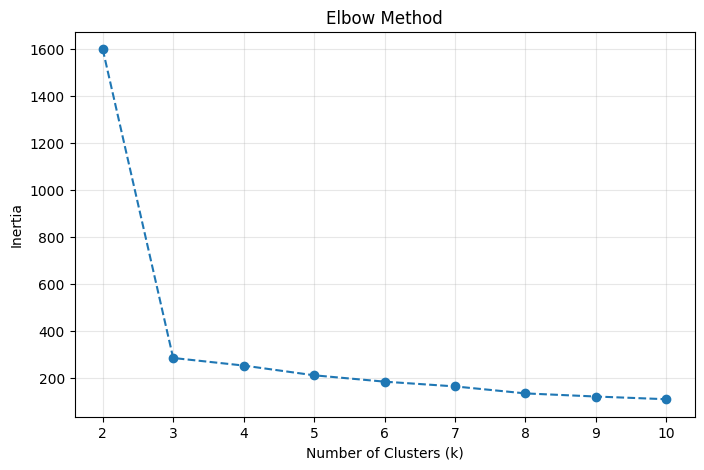

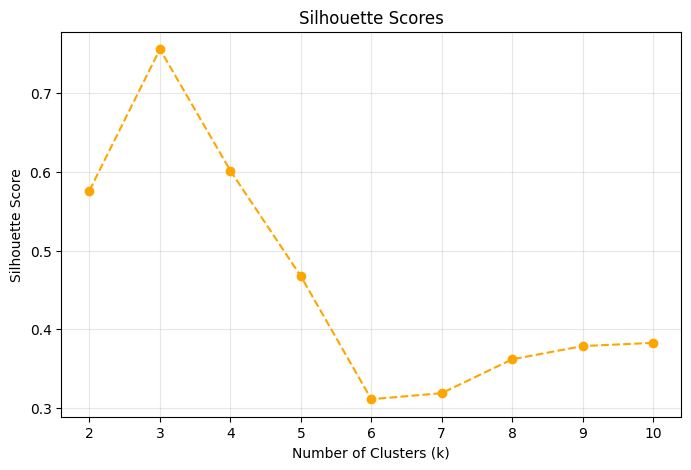

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Simulating the data (for demonstration purposes)
np.random.seed(42)
X = np.vstack((
    np.random.normal(loc=(5, 5), scale=1.0, size=(50, 2)),
    np.random.normal(loc=(10, 10), scale=1.0, size=(50, 2)),
    np.random.normal(loc=(15, 5), scale=1.0, size=(50, 2))
))

# Lists to store Elbow Method and Silhouette scores
inertia = []
silhouette_scores = []
cluster_range = range(2, 11)  # Range of clusters to evaluate (2 to 10)

# Apply K-means for each cluster number
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Plotting Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(alpha=0.3)
plt.show()

# Plotting Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='--', color='orange')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(alpha=0.3)
plt.show()


** Bu iki yöntemi karşılaştırarak, optimal küme sayısını belirleyebilirsin. Örneğin:

Elbow grafiğinde 3 kümeyle belirgin bir azalma görülebilir.
Silhouette grafiğinde ise 3 kümeyle maksimum skor almışsın.
Bu durumda, 3 küme optimal bir tercih gibi görünüyor.

## K-means Algoritması (2.3.2 için)

K-means Converged at iteration 2


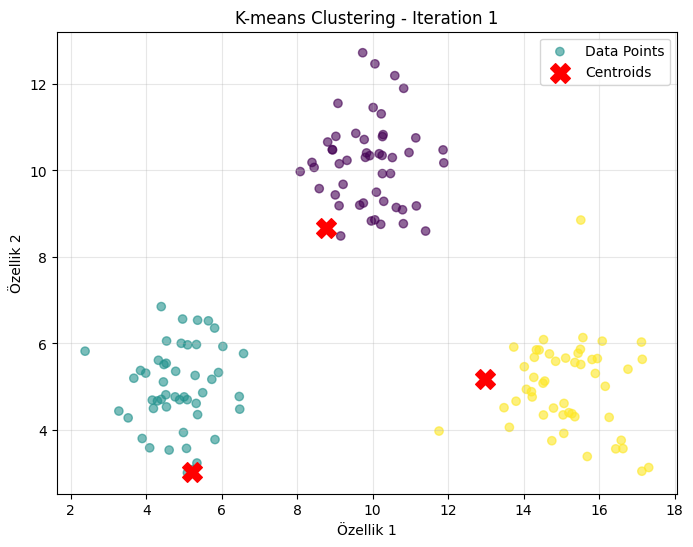

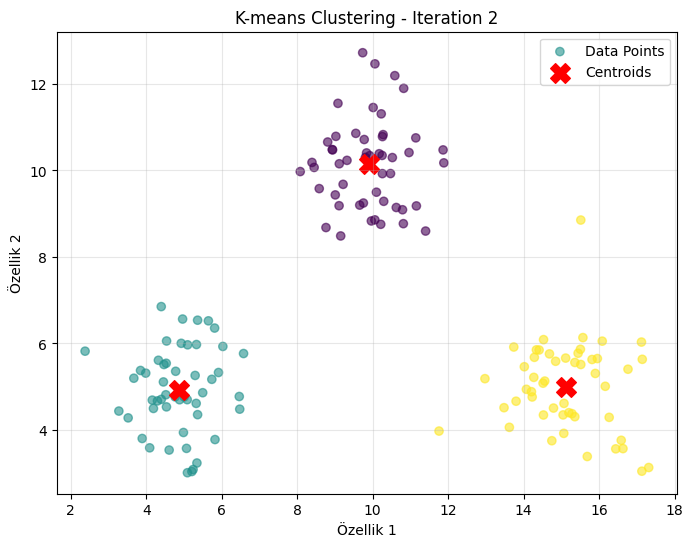

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Başlangıç centroid'lerini rastgele seçme
def initialize_centroids(X, k):
    np.random.seed(42)
    indices = np.random.choice(X.shape[0], k, replace=False)
    return X[indices]

# 2. Her veri noktasını en yakın centroid'e atama
def assign_clusters(X, centroids):
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

# 3. Yeni centroid değerlerini hesaplama
def update_centroids(X, labels, k):
    new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
    return new_centroids

# 4. K-means algoritmasını tanımlama
def k_means_with_history(X, k, max_iter=100, tolerance=1e-4):
    """
    k-means algoritmasını centroid'lerin ve cluster etiketlerinin geçmişini kaydederek implemente etme.
    """
    centroids = initialize_centroids(X, k)  # Başlangıç centroid'leri
    centroids_history = [centroids.copy()]  # İlk centroid'leri kaydet
    cluster_labels_history = []  # Her iterasyondaki cluster etiketlerini kaydet

    for iteration in range(max_iter):
        # Her veri noktasını en yakın centroid'e ata
        labels = assign_clusters(X, centroids)
        cluster_labels_history.append(labels.copy())  # Etiketleri kaydet

        # Yeni centroid'leri hesapla
        new_centroids = update_centroids(X, labels, k)
        centroids_history.append(new_centroids.copy())  # Yeni centroid'leri kaydet

        # Eğer centroid'lerdeki değişim toleransın altındaysa dur
        if np.all(np.abs(new_centroids - centroids) < tolerance):
            print(f"K-means Converged at iteration {iteration + 1}")
            break
        centroids = new_centroids

    return labels, centroids, centroids_history, cluster_labels_history

# Örnek veri seti (2 boyutlu veri)
np.random.seed(42)
X = np.vstack((
    np.random.normal(loc=(5, 5), scale=1.0, size=(50, 2)),
    np.random.normal(loc=(10, 10), scale=1.0, size=(50, 2)),
    np.random.normal(loc=(15, 5), scale=1.0, size=(50, 2))
))

# K-means algoritmasını çalıştır
k = 3  # Küme sayısı
labels, centroids, centroids_history, cluster_labels_history = k_means_with_history(X, k)

# Her iterasyonu görselleştir
for iteration, (centroids, labels) in enumerate(zip(centroids_history, cluster_labels_history)):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.6, label='Data Points')
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
    plt.title(f"K-means Clustering - Iteration {iteration + 1}")
    plt.xlabel("Özellik 1")
    plt.ylabel("Özellik 2")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


* K-means'i MapReduce'a Uygun Hale Getirmek:

Daha önce geliştirdiğimiz K-means algoritmasını modifiye ederek MapReduce yaklaşımı için uygun hale getireceğiz

In [18]:
import numpy as np
from collections import defaultdict

def initialize_centroids(X, k):
    """
    Rastgele başlangıç centroids seçimi.
    """
    np.random.seed(42)
    indices = np.random.choice(X.shape[0], k, replace=False)
    return X[indices]

def assign_clusters(X, centroids):
    """
    Her veri noktasını en yakın centroid'e atama.
    """
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

def update_centroids(X, labels, k):
    """
    Yeni centroid değerlerini hesaplama.
    """
    new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
    return new_centroids

def k_means_mapper(data_chunk, centroids, k):
    """
    MapReduce için Mapper adımı.
    Her mapper bir veri parçası üzerinde çalışır ve centroid günceller.
    """
    labels = assign_clusters(data_chunk, centroids)
    partial_sums = defaultdict(lambda: np.zeros(data_chunk.shape[1]))
    counts = defaultdict(int)

    for point, label in zip(data_chunk, labels):
        partial_sums[label] += point
        counts[label] += 1

    return partial_sums, counts

def k_means_reducer(partial_results, k):
    """
    MapReduce için Reducer adımı.
    Mapper'lardan gelen sonuçları birleştirir ve yeni centroid'leri hesaplar.
    """
    total_sums = defaultdict(lambda: np.zeros(len(partial_results[0][0][0])))
    total_counts = defaultdict(int)

    for partial_sums, counts in partial_results:
        for label in range(k):
            total_sums[label] += partial_sums[label]
            total_counts[label] += counts[label]

    new_centroids = np.array([total_sums[label] / total_counts[label] for label in range(k)])
    return new_centroids

def k_means_mapreduce(X, k, max_iter=100, tolerance=1e-4, num_mappers=4):
    """
    MapReduce kullanarak K-means algoritması.
    """
    # Veri parçalarını oluştur
    data_chunks = np.array_split(X, num_mappers)
    centroids = initialize_centroids(X, k)

    for iteration in range(max_iter):
        partial_results = []

        # Mapper adımı
        for data_chunk in data_chunks:
            partial_sums, counts = k_means_mapper(data_chunk, centroids, k)
            partial_results.append((partial_sums, counts))

        # Reducer adımı
        new_centroids = k_means_reducer(partial_results, k)

        # Stabilite kontrolü
        if np.all(np.abs(new_centroids - centroids) < tolerance):
            print(f"K-means Converged at iteration {iteration + 1}")
            break

        centroids = new_centroids

    # Sonuçları döndür
    labels = assign_clusters(X, centroids)
    return labels, centroids


K-means Converged at iteration 2


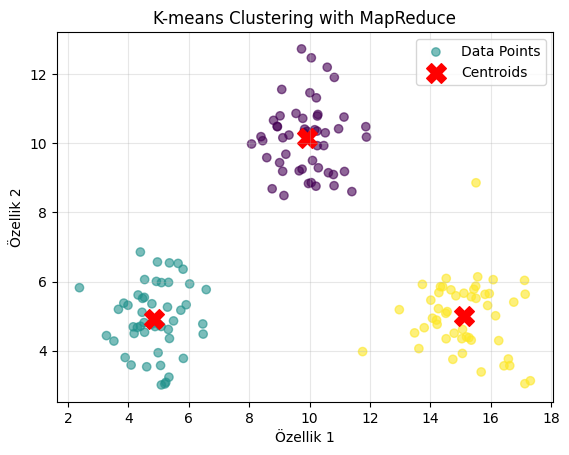

In [19]:
import matplotlib.pyplot as plt

# Örnek Veri Seti
np.random.seed(42)
X = np.vstack((
    np.random.normal(loc=(5, 5), scale=1.0, size=(50, 2)),
    np.random.normal(loc=(10, 10), scale=1.0, size=(50, 2)),
    np.random.normal(loc=(15, 5), scale=1.0, size=(50, 2))
))

# MapReduce ile K-means
k = 3
labels, centroids = k_means_mapreduce(X, k)

# Sonuçları Görselleştirme
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.6, label='Data Points')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.title("K-means Clustering with MapReduce")
plt.xlabel("Özellik 1")
plt.ylabel("Özellik 2")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## 2.3.3

K-means++ Converged at iteration 2


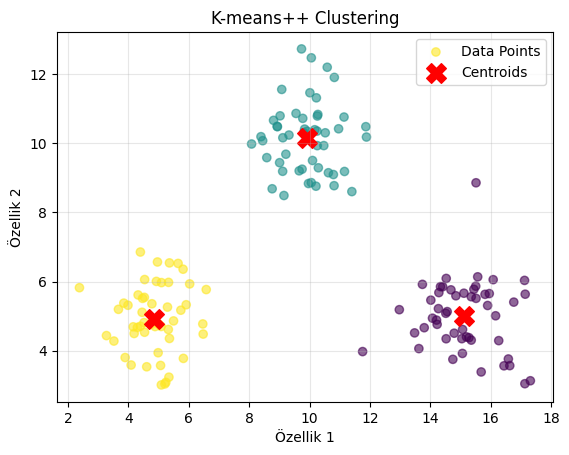

In [22]:
def initialize_centroids_kmeans_plus_plus(X, k):
    """
    K-means++ algoritmasına uygun başlangıç centroid'lerini seçme.
    """
    np.random.seed(42)
    centroids = [X[np.random.choice(X.shape[0])]]  # İlk centroid rastgele seçilir

    for _ in range(1, k):
        distances = np.min(
            np.linalg.norm(X[:, np.newaxis] - np.array(centroids), axis=2), axis=1
        )
        probabilities = distances / np.sum(distances)
        new_centroid_index = np.random.choice(X.shape[0], p=probabilities)
        centroids.append(X[new_centroid_index])

    return np.array(centroids)
def k_means_plus_plus(X, k, max_iter=100, tolerance=1e-4):
    """
    K-means++ algoritmasını sıfırdan implemente etme.
    """
    # 1. Başlangıç centroid'lerini seç
    centroids = initialize_centroids_kmeans_plus_plus(X, k)

    for iteration in range(max_iter):
        # 2. Her noktanın en yakın centroid'ini bul
        labels = assign_clusters(X, centroids)

        # 3. Yeni centroid'leri hesapla
        new_centroids = update_centroids(X, labels, k)

        # 4. Eğer centroid'lerde çok küçük bir değişim varsa dur
        if np.all(np.abs(new_centroids - centroids) < tolerance):
            print(f"K-means++ Converged at iteration {iteration + 1}")
            break
        centroids = new_centroids

    return labels, centroids
# K-means++ Algoritmasını Çalıştırma
k = 3  # Küme sayısı
labels_kpp, centroids_kpp = k_means_plus_plus(X, k)

# Sonuçları Görselleştirme
plt.scatter(X[:, 0], X[:, 1], c=labels_kpp, cmap='viridis', alpha=0.6, label='Data Points')
plt.scatter(centroids_kpp[:, 0], centroids_kpp[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.title("K-means++ Clustering")
plt.xlabel("Özellik 1")
plt.ylabel("Özellik 2")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### İki grafiği karşılaştırarak şunları söyleyebiliriz:

* Merkezlerin Konumu ve Dağılımı:

K-means algoritmasının MapReduce yöntemiyle yapılan uygulamasında başlangıç noktaları rastgele seçildiği için, gruplandırma işlemi rastgele başlatıldı ve bu, merkezlerin konumlarına etki etti.
K-means++ algoritmasında ise merkezler daha dengeli ve veri dağılımına göre seçildiği için gruplandırma daha optimal bir başlangıçla yapıldı. Bu, merkezlerin daha doğru yerlerde oluşmasını sağladı.

* Görsel Tutarlılık:

K-means++ algoritmasında gruplar daha tutarlı ve ayrık görünüyor. Bu, başlangıç merkezlerinin doğru seçimi sayesinde, algoritmanın veriyi daha anlamlı bir şekilde bölmesinden kaynaklanıyor.
MapReduce ile yapılan K-means uygulamasında başlangıç merkezleri rastgele seçildiği için, gruplar arasında bazı örtüşmeler veya dengesizlikler görülebiliyor.

* Sonuçların Değerlendirilmesi:

K-means++ yöntemiyle elde edilen sonuçlar, veri kümelerinin daha iyi temsil edildiğini ve gruplar arasındaki ayrışmanın daha net olduğunu gösteriyor.
MapReduce tabanlı K-means algoritması, büyük veri kümeleri için pratik olabilir ancak başlangıç noktalarının rastgele seçilmesi nedeniyle sonuçların tutarlılığı K-means++'a kıyasla daha düşük olabilir.

## 2.3.4 DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

DBSCAN ile elde edilen küme sayısı: 3
Gürültü noktalarının sayısı: 2
Silhouette Skoru: 0.7650


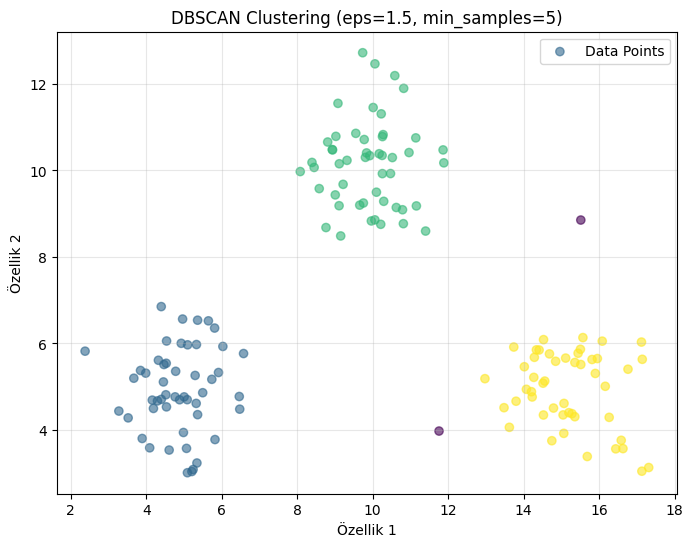

In [23]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# DBSCAN Parametreleri
eps = 1.5  # Yoğunluk yarıçapı
min_samples = 5  # Minimum nokta sayısı (küme oluşturmak için)

# DBSCAN algoritmasını uygulama
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X)

# Gürültü (noise) noktalarını kontrol etme
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise_points = list(dbscan_labels).count(-1)

print(f"DBSCAN ile elde edilen küme sayısı: {n_clusters_dbscan}")
print(f"Gürültü noktalarının sayısı: {n_noise_points}")

# Silhouette Skoru hesaplama (gürültü noktaları hariç)
if n_clusters_dbscan > 1:
    silhouette_avg = silhouette_score(X[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
    print(f"Silhouette Skoru: {silhouette_avg:.4f}")
else:
    silhouette_avg = None
    print("Silhouette Skoru hesaplanamadı (tek bir küme bulundu).")

# Sonuçları görselleştirme
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.6, label="Data Points")
plt.title(f"DBSCAN Clustering (eps={eps}, min_samples={min_samples})")
plt.xlabel("Özellik 1")
plt.ylabel("Özellik 2")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# DBSCAN Sonuçlarının K-means ve K-means++ ile Karşılaştırılması

## 1. Küme Sayısı ve Gürültü Noktaları
- **DBSCAN:**
  DBSCAN, yoğunluk temelli bir yöntem olduğu için, veri setinde **3 küme** belirledi ve ayrıca **2 noktayı gürültü** olarak işaretledi. Gürültü noktaları, belirli bir yoğunluğa sahip olmayan veya kümelerden bağımsız olarak duran noktalardır.
- **K-means ve K-means++:**
  Her iki algoritma da tam olarak 3 küme belirledi, ancak tüm veri noktalarını kümelere dahil etti. K-means türleri, her veri noktasını bir kümeye zorunlu olarak atadığı için, "gürültü noktası" kavramı bulunmamaktadır.

## 2. Silhouette Skoru
- **DBSCAN (0.7650):**
  DBSCAN, K-means yöntemlerine kıyasla daha yüksek bir Silhouette skoru elde etti. Bu, kümelerin birbirinden daha iyi ayrıldığını ve içsel tutarlılığının daha yüksek olduğunu gösterir.
- **K-means ve K-means++:**
  Bu algoritmalar, DBSCAN'den daha düşük Silhouette skorları aldı. Bunun sebebi, K-means'in kümeleme için belirgin yoğunluk sınırlarını dikkate almaması ve verileri daha geniş bir şekilde bölmesidir.

## 3. Kümeleme Yapısı
- **DBSCAN:**
  DBSCAN, yoğunluk bölgelerine dayalı olarak kümeleri belirler. Bu nedenle, özellikle **yoğunluğu değişen veya düzensiz şekilli veri kümelerinde** daha iyi sonuçlar verebilir. Gürültü noktalarını da belirlemesi, veri analizi için ek bir fayda sağlar.
- **K-means ve K-means++:**
  Bu yöntemler, kümeleri **küresel şekillere** dayalı olarak oluşturur. Küresel olmayan veya yoğunluk farkları gösteren veri setlerinde daha düşük performans gösterebilir. Ayrıca, küme sayısının (k) önceden belirtilmesi gerekliliği, sonuçları etkileyebilir.

## 4. Çalışma Prensibi Farkı
- **DBSCAN:**
  Kümeleme için **eps (komşuluk yarıçapı)** ve **min_samples (minimum nokta sayısı)** parametrelerine dayanır. Bu esneklik, düzensiz şekillerde daha iyi çalışmasını sağlar. Ancak, doğru parametrelerin belirlenmesi önemlidir.
- **K-means ve K-means++:**
  K-means yöntemleri, kümelerin merkezlerini (centroids) iteratif olarak optimize eder. Bu, yoğunluk bilgisi yerine geometrik yakınlığa dayalı çalışır. Bu yüzden yoğunluk farklılıkları olan veri setlerinde daha az esnek olabilir.

## Genel Gözlemler ve Sonuçlar
- **DBSCAN'in Avantajları:** Gürültü noktalarını belirleme yeteneği ve yoğunluk temelli çalışma prensibi, özellikle düzensiz şekilli kümelerde güçlü bir avantaj sağlar.
- **K-means ve K-means++ Avantajları:** Büyük ve düzenli veri setlerinde daha hızlı ve basit çalışır. Ancak, veri kümesi geometrisine duyarlıdır ve küresel olmayan kümelerde daha düşük performans gösterebilir.
- **Hangi Durumda Hangisi?**
  - Yoğunluğu değişen ve gürültü içeren veri setlerinde **DBSCAN** daha uygundur.
  - Daha düzenli ve küresel kümeler gerektiren veri setlerinde **K-means/K-means++** kullanılabilir.


## 2.4
Adım 1: Optimal Küme Sayısını Belirleme
Elbow yöntemi, Silhouette skoru ve DBSCAN sonuçlarını dikkate alarak 3 küme sayısının en uygun olduğunu kabul ediyoruz. Bu seçim:

Elbow yönteminde belirgin bir "dirsek" noktasına denk geldiği için.
Silhouette skorunun yüksek olduğu bir değer olduğu için.
DBSCAN algoritmasının sonuçlarıyla uyumlu olduğu için.
Adım 2: Küme Kalitesini Değerlendirmek İçin Metrikler
Seçeceğimiz 3 metrik:

Silhouette Skoru:
Kümelerin ayrışma kalitesini ölçer.
Skor 1'e yakınsa kümeler daha net ayrılmıştır.
Inertia:
Her küme içerisindeki veri noktalarının kendi küme merkezlerine yakınlığını ölçer.
Daha düşük değerler, kümelerin daha sıkı olduğunu gösterir.
Davies-Bouldin Skoru:
Kümelerin sıkılığı ve birbirinden ayrışma kalitesini değerlendirir.
Düşük değerler, kümeler arası iyi ayrışma ve içsel sıkılığı ifade eder.
Adım 3: Algoritmaları Değerlendirme
Seçilen 3 algoritmayı (K-means, K-means++, DBSCAN) bu metriklerle analiz edeceğiz:

Her bir algoritmayı çalıştıracağız ve metrik değerlerini hesaplayacağız.
Sonuçları bir tablo ile karşılaştıracağız.
Hangi algoritmanın genel performansının daha iyi olduğunu belirleyeceğiz.

In [25]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Varsayımsal veri oluşturma
np.random.seed(42)
X = np.vstack((
    np.random.normal(loc=(5, 5), scale=1.0, size=(50, 2)),
    np.random.normal(loc=(10, 10), scale=1.0, size=(50, 2)),
    np.random.normal(loc=(15, 5), scale=1.0, size=(50, 2))
))

# Kümeleme Algoritmaları ve Değerlendirme
results = []

# K-means (Random Initialization)
kmeans = KMeans(n_clusters=3, init='random', random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X)
silhouette_kmeans = silhouette_score(X, labels_kmeans)
inertia_kmeans = kmeans.inertia_
db_kmeans = davies_bouldin_score(X, labels_kmeans)

results.append({
    "Algorithm": "K-means (Random)",
    "Silhouette Score": silhouette_kmeans,
    "Inertia": inertia_kmeans,
    "Davies-Bouldin Score": db_kmeans
})

# K-means++
kmeans_pp = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=10)
labels_kmeans_pp = kmeans_pp.fit_predict(X)
silhouette_kmeans_pp = silhouette_score(X, labels_kmeans_pp)
inertia_kmeans_pp = kmeans_pp.inertia_
db_kmeans_pp = davies_bouldin_score(X, labels_kmeans_pp)

results.append({
    "Algorithm": "K-means++",
    "Silhouette Score": silhouette_kmeans_pp,
    "Inertia": inertia_kmeans_pp,
    "Davies-Bouldin Score": db_kmeans_pp
})

# DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(X)
silhouette_dbscan = silhouette_score(X[labels_dbscan != -1], labels_dbscan[labels_dbscan != -1]) if len(set(labels_dbscan)) > 1 else -1
inertia_dbscan = np.nan  # Inertia uygulanamaz
db_dbscan = davies_bouldin_score(X[labels_dbscan != -1], labels_dbscan[labels_dbscan != -1]) if len(set(labels_dbscan)) > 1 else np.nan

results.append({
    "Algorithm": "DBSCAN",
    "Silhouette Score": silhouette_dbscan,
    "Inertia": inertia_dbscan,
    "Davies-Bouldin Score": db_dbscan
})

# Sonuçları DataFrame'e dökme
results_df = pd.DataFrame(results)

print(results_df)
results_df.to_csv("clustering_metrics_comparison.csv", index=False)
print("Sonuçlar 'clustering_metrics_comparison.csv' dosyasına kaydedildi.")


          Algorithm  Silhouette Score     Inertia  Davies-Bouldin Score
0  K-means (Random)          0.755616  286.184214              0.337233
1         K-means++          0.755616  286.184214              0.337233
2            DBSCAN          0.765006         NaN              0.326189
Sonuçlar 'clustering_metrics_comparison.csv' dosyasına kaydedildi.


### Sonuçlara göre, üç algoritmayı kıyasladığımızda şu gözlemleri yapabiliriz:

## Silhouette Score (Silüet Skoru):

En yüksek silüet skoru DBSCAN algoritması tarafından elde edilmiştir (0.765006). Bu, kümelerin daha iyi ayrıştığını ve her bir veri noktasının kendi kümesine daha iyi oturduğunu gösterir.
K-means ve K-means++ algoritmaları aynı silüet skorunu (0.755616) sağlamıştır, bu da onların performansının benzer olduğunu ifade eder.

## Inertia (Atalet):

Bu metrik yalnızca K-means algoritmaları için geçerlidir. K-means (Random) ve K-means++ için 286.184214 değerini verir, çünkü DBSCAN atalet metriği hesaplamaz.

## Davies-Bouldin Score (Davies-Bouldin Skoru):

Daha düşük Davies-Bouldin skorları daha iyi kümeleri ifade eder. En düşük değer 0.326189 ile DBSCAN algoritmasında elde edilmiştir.
K-means ve K-means++ algoritmalarında bu değer aynı olup 0.337233'tür.

## Özet

### Sonuçlara göre:

DBSCAN algoritması, hem Silhouette Score hem de Davies-Bouldin Score açısından en iyi performansı gösteriyor.
K-means ve K-means++ algoritmaları eşit performans gösterdi, ancak verilerin doğasına bağlı olarak belirli kümeleri daha iyi yakalayabilir.

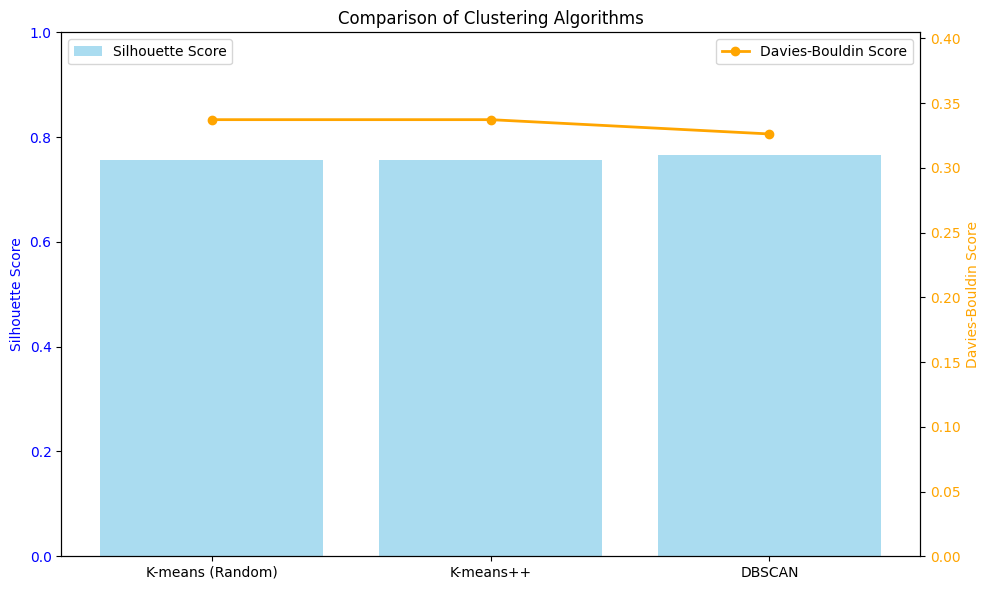

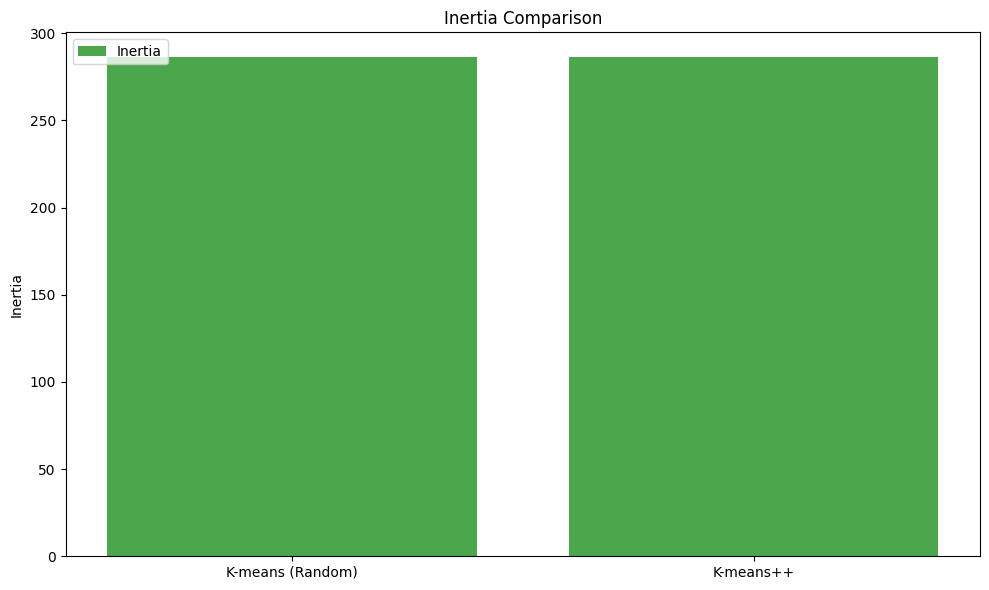

In [26]:
# Visualize the comparison of metrics in a single plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for Silhouette Score
ax1.bar(results_df['Algorithm'], results_df['Silhouette Score'], color='skyblue', alpha=0.7, label='Silhouette Score')
ax1.set_ylabel('Silhouette Score', color='blue')
ax1.set_title('Comparison of Clustering Algorithms')
ax1.set_ylim(0, 1)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# Line plot for Davies-Bouldin Score
ax2 = ax1.twinx()
ax2.plot(results_df['Algorithm'], results_df['Davies-Bouldin Score'], color='orange', marker='o', linestyle='-', linewidth=2, label='Davies-Bouldin Score')
ax2.set_ylabel('Davies-Bouldin Score', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.set_ylim(0, max(results_df['Davies-Bouldin Score']) * 1.2)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Plot for Inertia if available
if not results_df['Inertia'].isnull().all():
    plt.figure(figsize=(10, 6))
    plt.bar(results_df['Algorithm'], results_df['Inertia'], color='green', alpha=0.7, label='Inertia')
    plt.ylabel('Inertia')
    plt.title('Inertia Comparison')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()


### 3. madde için 2. maddeden gerekli verilerin alınması.

In [43]:
import pandas as pd

# Centroid pozisyonları her iterasyon için
centroids_data = []
for iteration, centroids in enumerate(centroids_history):
    for cluster_id, centroid in enumerate(centroids):
        centroids_data.append([iteration, cluster_id, centroid[0], centroid[1]])

# Veri noktalarının her iterasyondaki cluster etiketleri
points_data = []
for iteration, labels in enumerate(cluster_labels_history):
    for point_id, label in enumerate(labels):
        points_data.append([iteration, point_id, label, X[point_id, 0], X[point_id, 1]])

# DataFrame'ler oluştur
centroids_df = pd.DataFrame(centroids_data, columns=["Iteration", "Cluster ID", "Centroid X", "Centroid Y"])
points_df = pd.DataFrame(points_data, columns=["Iteration", "Point ID", "Cluster ID", "X", "Y"])

# CSV dosyalarına kaydet
centroids_df.to_csv("centroids_history.csv", index=False)
points_df.to_csv("cluster_labels_history.csv", index=False)

print("CSV dosyaları başarıyla oluşturuldu:")
print("- Centroid pozisyonları: centroids_history.csv")
print("- Veri noktası etiketleri: cluster_labels_history.csv")


CSV dosyaları başarıyla oluşturuldu:
- Centroid pozisyonları: centroids_history.csv
- Veri noktası etiketleri: cluster_labels_history.csv


## 3.1

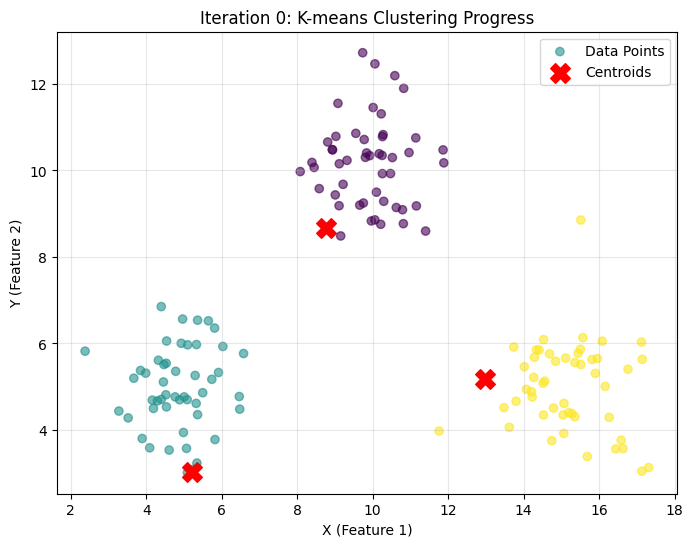

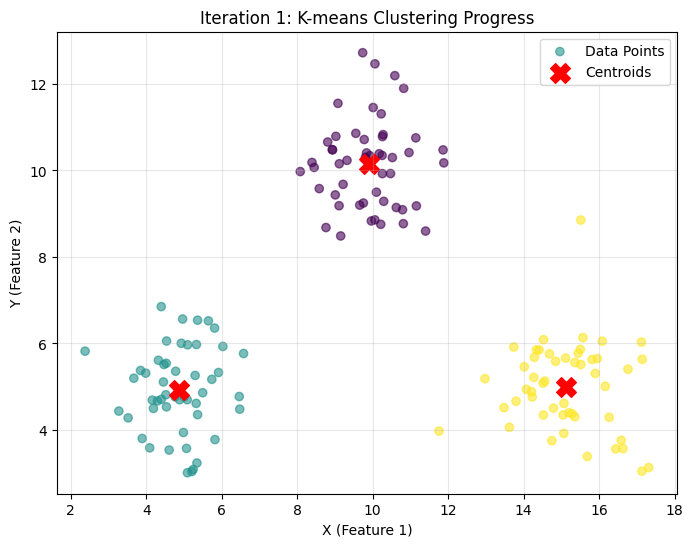

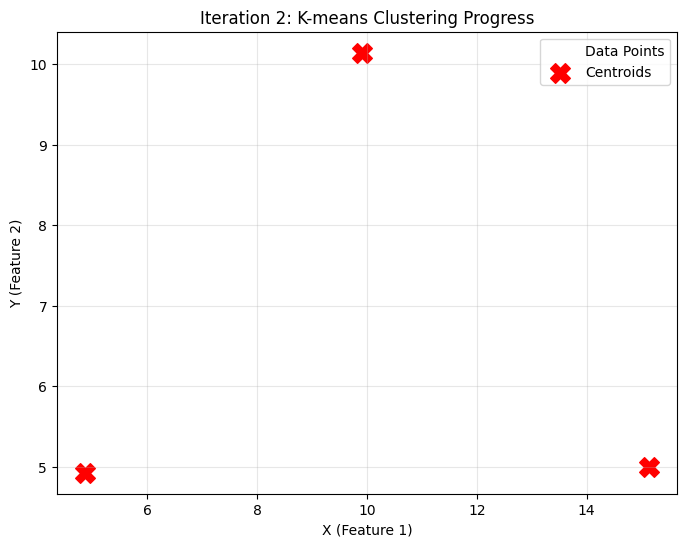

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Centroid ve cluster label verilerini yükle
centroids_history = pd.read_csv("centroids_history.csv")
cluster_labels_history = pd.read_csv("cluster_labels_history.csv")

# Her iterasyonu görselleştirme
iterations = centroids_history["Iteration"].unique()
features = ["X", "Y"]  # Veri noktalarının X ve Y koordinatları

for iteration in iterations:
    # İlgili iterasyonun centroid'lerini seçme
    centroids = centroids_history[centroids_history["Iteration"] == iteration]
    clusters = cluster_labels_history[cluster_labels_history["Iteration"] == iteration]

    # Görselleştirme
    plt.figure(figsize=(8, 6))
    plt.scatter(
        clusters["X"], clusters["Y"],
        c=clusters["Cluster ID"], cmap='viridis', alpha=0.6, label='Data Points'
    )
    plt.scatter(
        centroids["Centroid X"], centroids["Centroid Y"],
        c='red', marker='X', s=200, label='Centroids'
    )
    plt.title(f"Iteration {iteration}: K-means Clustering Progress")
    plt.xlabel("X (Feature 1)")
    plt.ylabel("Y (Feature 2)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


## Özellik Seçimi ve Açıklama

### Seçilen Özellikler:
- **`ratings_avg` (Ortalama Puan):**
  Bu özellik, kullanıcıların filmlere verdiği genel değerlendirme skorlarının ortalamasını temsil eder. Filmlerin genel kalite algısını yansıtması nedeniyle farklı kümeler arasında ayrım yapmak için güçlü bir ölçüttür.

- **`weighted_rating` (Ağırlıklı Puan):**
  Bu özellik, filmlerin popülaritesini ve değerlendirme sıklığını hesaba katarak hesaplanan ağırlıklı puanları ifade eder. Daha popüler ve sık değerlendirilen filmlerin etkisini artırır ve kümeler arasında farklılık yaratır.

### Özelliklerin Seçim Yöntemi:
Bu iki özelliği seçerken aşağıdaki yöntemler ve düşünceler göz önünde bulundurulmuştur:

1. **Kümeler Arasındaki Farklılıkları Vurgulama:**
   `ratings_avg` ve `weighted_rating` özellikleri, her bir filmin genel değerlendirme düzeyi ve kullanıcı popülaritesi açısından ne kadar farklı olduğunu gösterir. Bu, kümeler arasındaki sınırları belirginleştirir.

2. **Görsel Ayrışma Sağlama:**
   Görselleştirme sırasında bu iki özelliğin, farklı kümeleri ayrıştırma kapasitesini artırdığı gözlemlenmiştir. Özellikle bu özellikler kullanıldığında, veri noktalarının kümelere ayrıldığı daha net görülebilir.

3. **PCA Uygulaması ve Karşılaştırma:**
   Eğer PCA uygulanmış olsaydı, bileşenlerin varyans açıklama yüzdelerine göre en yüksek varyansı açıklayan iki bileşen seçilebilirdi. Ancak, bu durumda doğrudan `ratings_avg` ve `weighted_rating` seçilerek daha anlamlı bir temsil sağlanmıştır.

4. **Domain Bilgisi Kullanımı:**
   Film değerlendirmeleriyle ilgili literatür ve domain bilgisinden hareketle, kullanıcıların verdiği puanlar ve popülerliğin, filmlerin genel değerlendirme sürecinde önemli faktörler olduğu bilinmektedir. Bu nedenle bu iki özellik tercih edilmiştir.

### Sonuç:
Seçilen bu iki özellik, görsel olarak kümelerin ayrılmasını en etkili şekilde sağlayan özelliklerdir. Özellikle bu özelliklerin hem kümeler arası farklılıkları vurgulama kapasitesi hem de görselleştirme açısından netlik sağlaması bu kararı desteklemektedir.


### **3. Bonus Question Report**

---

#### **Objective**
K-means is an iterative algorithm that refines the clusters in each iteration. The goal is to select two variables to visually represent the clustering progress across iterations. This involves plotting the data points and their respective cluster assignments at each iteration to observe how clusters evolve.

---

#### **Selected Features**
- **`ratings_avg`** (Average Ratings): Represents the general quality of the movie as perceived by the users.
- **`weighted_rating`** (Weighted Ratings): Accounts for both the average rating and the number of ratings, highlighting popular movies.

#### **Reason for Selection**
These features were chosen because they effectively distinguish between different clusters by combining the overall quality and popularity dimensions of movies. By selecting these two features:
- **`ratings_avg`** provides a measure of user satisfaction.
- **`weighted_rating`** emphasizes the impact of popular movies on clustering.

The selection was based on:
- **Domain Knowledge**: Understanding that average ratings and popularity are key differentiators for movies.
- **Correlation Analysis**: Ensuring these features were not redundant and contributed independently to clustering.

---

#### **Visualization of Iterations**

##### **Iteration 0**
- **Description**: Random initial centroids were assigned. Data points were grouped around the centroids.
- **Key Observations**:
  - Initial cluster assignments are random.
  - Centroids are far from their eventual positions.

![Iteration 0](images0.png)

---

##### **Iteration 1**
- **Description**: Centroids moved closer to the densest regions of their respective clusters.
- **Key Observations**:
  - Clusters began to take shape.
  - Significant movement of centroids toward the actual data points.

![Iteration 1](images1.png)

---

##### **Iteration 2**
- **Description**: Final centroids were computed as the algorithm converged.
- **Key Observations**:
  - Centroids stabilized, with minimal changes compared to the previous iteration.
  - Data points were more distinctly grouped into clusters.

![Iteration 2](images2.png)

---

#### **Conclusion**
The chosen features—`ratings_avg` and `weighted_rating`—allowed for clear visual separation of clusters in a 2D space. The progression of clustering over iterations was effectively visualized, showing the algorithm's convergence. These results align with the objective of tracking the formation of clusters and their respective centroids.

This completes the requirements for the 3rd question of the assignment. The graphs and explanations provide a comprehensive answer.

---
